## Prudential Financial - MLE Exercise

**Aim**: Build a ML model to predict BMI and use the predicted BMI to share insurance quote

**Import required libraries**

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings("ignore")

import lightgbm as lgbm
import xgboost as xg

from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures

### Data Loading

**Read the data from Dummy-Data.csv**

In [3]:
df = pd.read_csv(r'C:\Users\amrut\Documents\Prudential\Dummy-Data.csv')
df.head()

,AppID,Ins_Age,Ins_Gender,Ht,Wt,IssueDate
0,56372,31,Male,510,185,NaN
1,34565,35,Male,510,205,NaN
2,57732,45,Female,510,125,NaN
3,87324,38,Male,503,175,NaN
4,12323,39,Female,600,252,NaN


### Data Cleaning

**Convert the "Ht" column into Height in inches**

In [4]:
ft, inch = divmod(df['Ht'], 100)
df['height'] = ft * 12 + inch
df.head()

,AppID,Ins_Age,Ins_Gender,Ht,Wt,IssueDate,height
0,56372,31,Male,510,185,NaN,70
1,34565,35,Male,510,205,NaN,70
2,57732,45,Female,510,125,NaN,70
3,87324,38,Male,503,175,NaN,63
4,12323,39,Female,600,252,NaN,72


**Check if any of the columns have NULL values**

In [5]:
df.isnull().any()

AppID         False
Ins_Age       False
Ins_Gender    False
Ht            False
Wt            False
IssueDate      True
height        False
dtype: bool

**Check if all the values in the "IssueDate" column are NULL** so that it can be dropped as it does not provide any useful information towards predicting BMI.

In [6]:
df['IssueDate'].isnull().all()

True

- The AppID can be dropped as it does not provide any useful information.
- IssueDate column has only NaN value and hence can be dropped.
- As we converted height into inches the old column Ht can be dropped.

In [7]:
df.drop(columns=["IssueDate", "AppID", "Ht"], inplace=True)

Let's rename the columns to make them easy to understand.

In [8]:
df = df.rename(columns={"Ins_Age": "age", "Ins_Gender": "gender", "Wt":"weight"})
df.head()

,age,gender,weight,height
0,31,Male,185,70
1,35,Male,205,70
2,45,Female,125,70
3,38,Male,175,63
4,39,Female,252,72


**Calculate BMI (which is our target variable)**

In [9]:
def calculateBMI(ht_list, wt_list):
    bmi = list()
    
    for h, w in zip(ht_list, wt_list):
        bmi.append((w/(h*h)) * 703)
        
    return bmi

bmi = calculateBMI(list(df.height), list(df.weight))

df = df.assign(BMI = bmi)
df.head()

,age,gender,weight,height,BMI
0,31,Male,185,70,26.541837
1,35,Male,205,70,29.411224
2,45,Female,125,70,17.933673
3,38,Male,175,63,30.996473
4,39,Female,252,72,34.173611


### Data Profiling

In [10]:
display(df.describe())
display(df.describe(include=['O']))

,age,weight,height,BMI
count,100.000000,100.00000,100.000000,100.000000
mean,37.320000,165.15000,68.360000,25.080756
std,12.103827,27.66224,3.945385,4.930205
min,19.000000,110.00000,60.000000,15.405405
25%,27.750000,145.00000,66.000000,22.082227
50%,36.000000,170.00000,69.000000,25.085424
75%,47.000000,180.00000,71.000000,28.260810
max,59.000000,275.00000,77.000000,39.454082


,gender
count,100
unique,2
top,Male
freq,63


1. Age ranges from 19 to 59

2. Weight ranges from 110 lbs to 275 lbs

3. Height ranges from 60 inches to 77 inches

4. Male customers are 63 in number and Female are 34.

### Data Visualization
Now that our data is clean , we will look at visualizations and drawing correlations among features and target variable(BMI)

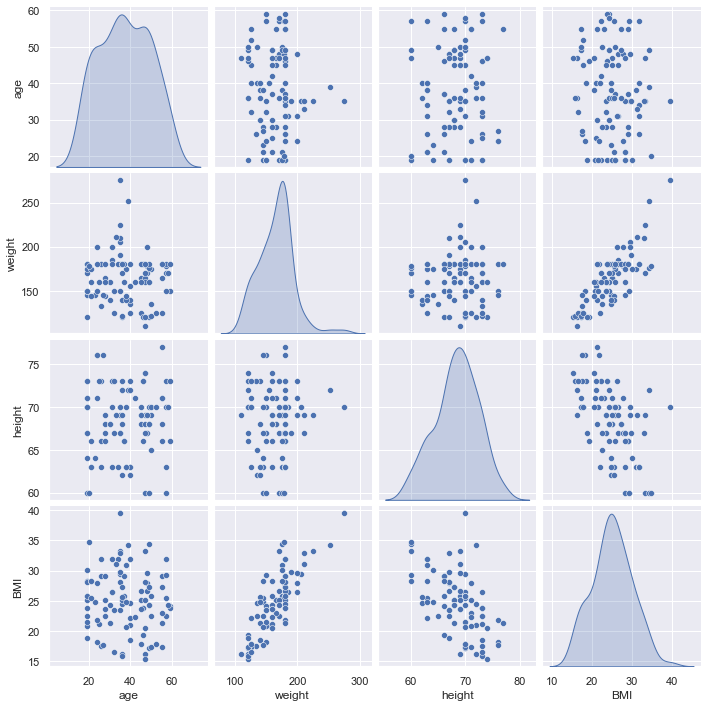

In [11]:
#histogram to see distribution of data points
sns.pairplot(data=df, diag_kind='kde')
plt.show()

There is not much skewness in the data. 

**Gender**

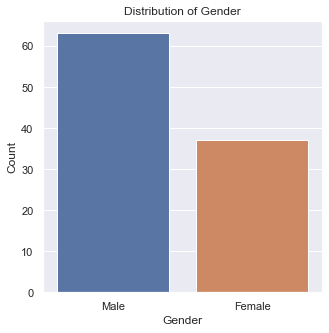

In [12]:
# Get the count of Gender

plt.figure(figsize = (5, 5))
# creating the bar plot
sns.countplot(df.gender)
plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Distribution of Gender")
plt.show()

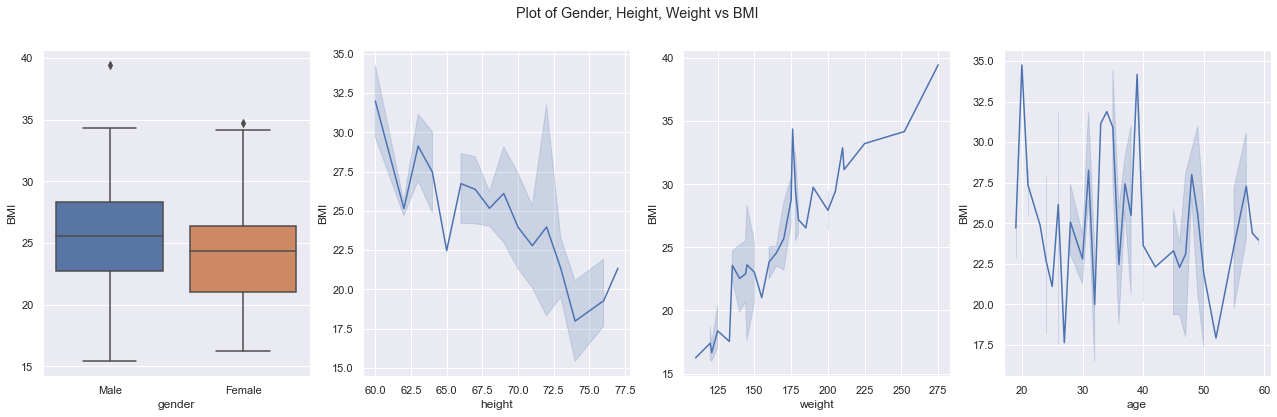

In [13]:
fig, ax2 = plt.subplots(1,4,  figsize=(22,6))
fig.suptitle('Plot of Gender, Height, Weight vs BMI',)
sns.boxplot(ax=ax2[0], x=df.gender, y=df.BMI)
sns.lineplot(ax=ax2[1], x=df.height, y=df.BMI)
sns.lineplot(ax=ax2[2], x=df.weight, y=df.BMI)
sns.lineplot(ax=ax2[3], x=df.age, y=df.BMI)
plt.show()

**Subplot 1:** BMI in Male customers is higher than Female customers

**Subplot 2:** BMI decreases as Height increases, if weight is kept constant. BMI and Height are inversely proportional.

**Subplot 3:** BMI increases as Weight increases, if height is kept constant. BMI and Weight are directly proportional.

**Subplot 4:** Age has no effect on BMI. The plot shows the BMI with respect to Age.

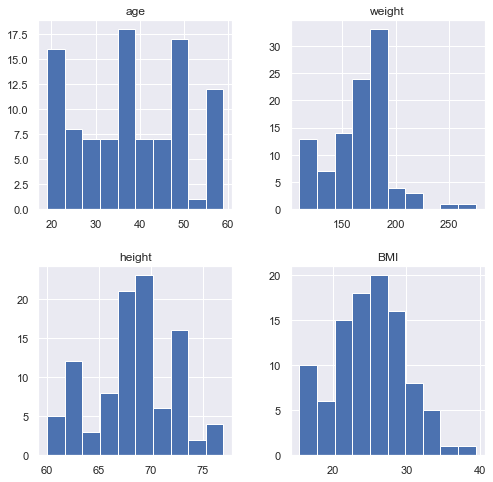

In [14]:
df.hist(figsize = (8, 8))
plt.show()

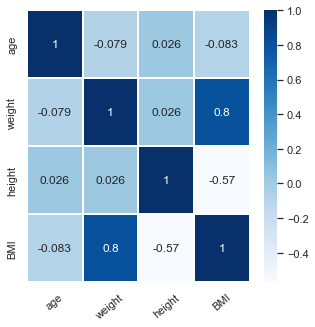

In [15]:
#Correlation map between numeric features - age, height, weight and bmi

plt.figure(figsize=(5,5))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, cmap = 'Blues', annot=True, linewidths=0.1, linecolor='white')
plt.xticks(rotation = 40)
plt.show()

**BMI and Weight have strong positive correlation.**

**BMI and Height have strong negative correlation.**

**BMI and Age have negative correlation**

**We will not remove Weight column as it is an important feature in predicting BMI.**

### Data Preprocessing and Feature Engineering

**Encode "gender" column using One Hot Encoding**

In [16]:
#generate binary values using Sklearn
# creating instance of one-hot-encoder
ohenc = OneHotEncoder(handle_unknown='ignore', drop='first')

#Passing gender variable
encDF = pd.DataFrame(ohenc.fit_transform(df[['gender']]).toarray())

# replace the column with encoded values in the original dataset
df['gender']= encDF
df.head()

,age,gender,weight,height,BMI
0,31,1.0,185,70,26.541837
1,35,1.0,205,70,29.411224
2,45,0.0,125,70,17.933673
3,38,1.0,175,63,30.996473
4,39,0.0,252,72,34.173611


**Saving the OneHotEncoder model for future use**

In [17]:
with open('onehotencoder.pkl', 'wb') as file:
    pickle.dump(ohenc, file)

**Create X and y datasets to segragate independent features and dependent feature respectively**

In [18]:
# create the X and y datasets to segragate independent features and dependent feature respectively

X = df[['age', 'height', 'weight', 'gender']]
y = df['BMI']

**Split the data into training and test datasets**

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1234)

**Perform feature engineering using Polynomial Features Transform: Create new features based on existing ones.**

In [20]:
# Creating Polynomial Features with a degree of 3 that will add two new variables for each input variable.
poly = PolynomialFeatures(degree=3)

X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

**Saving Polynomial Feature Transform model for future use**

In [21]:
with open('polynomialFT.pkl', 'wb') as file:
    pickle.dump(poly, file)

**Training and Testing Linear Regression, Ridge Regression, Decision Tree Regressor models on**

**1. X_train and X_test**

**2. X_train and X_test after applying Polynomial Features Transform (X_train_poly, X_test_poly)**

**Storing the scores such as R2, MAE, RMSE into a dataframe**

**Function to fit the model, predict on test set and evaluate metrics**

In [22]:
def model_fit_predict(model, X_train, y_train, X_test, y_test, suffix):
    
    model.fit(X_train, y_train)
    yhat = model.predict(X_test)
    algoname = model.__class__.__name__ + suffix
    
    return algoname, round(r2_score(y_test, yhat),4), round(mean_absolute_error(y_test, yhat),4), round(np.sqrt(mean_squared_error(y_test, yhat)),4)

In [23]:
algo=[LinearRegression(), Ridge(), DecisionTreeRegressor(random_state=200)]
score=[]
for a in algo:
    score.append(model_fit_predict(a, X_train, y_train, X_test, y_test, suffix=""))
    score.append(model_fit_predict(a, X_train_poly, y_train, X_test_poly, y_test, suffix="_poly"))

**Metrics DataFrame**

In [24]:
metrics = pd.DataFrame(score, columns=['Model', 'R2Score', 'MAE', 'RMSE'])
metrics

,Model,R2Score,MAE,RMSE
0,LinearRegression,0.9880,0.2633,0.3808
1,LinearRegression_poly,1.0000,0.0027,0.0054
2,Ridge,0.9880,0.2632,0.3796
3,Ridge_poly,0.9996,0.0462,0.0662
4,DecisionTreeRegressor,0.8973,0.8657,1.1131
5,DecisionTreeRegressor_poly,0.7782,1.2124,1.6354


**From the above metrics dataframe, we can see that Linear Regression model with Polynomial Features Transform outperforms the other 2 models.**

Tried Scaling X_train and X_test after applying Polynomial Features Transform but there was no difference between the metrics of Polynomial Features and Scaled Polynomial Features.

**Let's fit Linear Regression model using Polynomial Features**

In [25]:
linreg_poly = LinearRegression()
linreg_poly.fit(X_train_poly, y_train)
yhat_lr_poly = linreg_poly.predict(X_test_poly)

**Saving the Linear Regression poly model for future use**

In [26]:
with open('linregmodel.pkl', 'wb') as file:
    pickle.dump(linreg_poly, file)

## Performing different set of feature engineering, training and testing ensemble models

**As a part of Feature Engineering process, Let's group similar customers into clusters using KMeans.**

**Creating a copy of original df into df2**

In [27]:
df2 = df.copy()
features = ['age', 'height', 'weight', 'gender']
df2[features].head()

,age,height,weight,gender
0,31,70,185,1.0
1,35,70,205,1.0
2,45,70,125,0.0
3,38,63,175,1.0
4,39,72,252,0.0


**Visualizing the elbow method to select the optimal number of clusters**

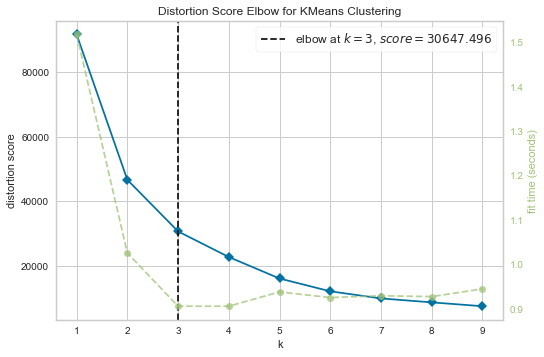

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [28]:
from yellowbrick.cluster import KElbowVisualizer

km = KMeans(random_state=21)
visualizer = KElbowVisualizer(km, k=(1,10))
visualizer.fit(df2[features])        # Fit the data to the visualizer
visualizer.show()

**The dotted line above indicates the elbow and a good indication that the underlying model fits best at that point.**

**Therefore create 3 clusters using KMeans and fit the dataset**

In [29]:
kmeans = KMeans(n_clusters=3, random_state=84)
kmeans.fit(df2[features])

KMeans(n_clusters=3, random_state=84)

**Create a new feature using the labels (0,1,2).**

In [30]:
df2['cust_type'] = kmeans.labels_
df2.head()

,age,gender,weight,height,BMI,cust_type
0,31,1.0,185,70,26.541837,0
1,35,1.0,205,70,29.411224,2
2,45,0.0,125,70,17.933673,1
3,38,1.0,175,63,30.996473,0
4,39,0.0,252,72,34.173611,2


**Selecting 4 best columns to train the model**

In [31]:
p = df2[['age', 'height', 'weight', 'gender', 'cust_type']]
q = df2['BMI']

# Create and fit selector

KBest = SelectKBest(f_regression, k=4) 
KBest.fit(p,q)

# Get columns to keep and create new dataframe with those only
cols = KBest.get_support(indices=True)
new_df = p.iloc[:,cols] 
new_df.head()

,height,weight,gender,cust_type
0,70,185,1.0,0
1,70,205,1.0,2
2,70,125,0.0,1
3,63,175,1.0,0
4,72,252,0.0,2


**Height, Weight, Gender and cust_type are the 4 columns selected using SelectKBest.**

Let us now take these columns as independent variables and BMI as dependent variable into X and y respectively.

In [32]:
# Selecting X and Y 
X = new_df.copy()
y = df2['BMI']

#Split test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=543)

**Perform scaling after splitting the data into train and test to avoid data leak into test dataset.**

**I scaled the data as I am evaluating both Linear Model and Tree based models.**

In [33]:
numeric=['height', 'weight']
rs=RobustScaler()
X_train[numeric]=rs.fit_transform(X_train[numeric])
X_test[numeric]=rs.transform(X_test[numeric])

**Fitting and Predicting using Linear Regression model, Decision Trees and Ensemble models.**

In [34]:
def evaluate_models(model):
    model.fit(X_train, y_train)
    yhat = model.predict(X_test)
    algoname = model.__class__.__name__
    return algoname, round(r2_score(y_test, yhat),4), round(mean_absolute_error(y_test, yhat),4), round(np.sqrt(mean_squared_error(y_test, yhat)),4)

In [35]:
algorithms = [LinearRegression(),
              DecisionTreeRegressor(),
              RandomForestRegressor(), 
              GradientBoostingRegressor(), 
              lgbm.LGBMRegressor(), 
              xg.XGBRFRegressor()]
eval_score = []
for alg in algorithms:
    eval_score.append(evaluate_models(alg))

In [36]:
all_metrics = pd.DataFrame(eval_score, columns=['Model', 'R2Score', 'MAE', 'RMSE'])
all_metrics

,Model,R2Score,MAE,RMSE
0,LinearRegression,0.9928,0.2641,0.3174
1,DecisionTreeRegressor,0.9268,0.7101,1.0086
2,RandomForestRegressor,0.9523,0.6415,0.8140
3,GradientBoostingRegressor,0.9816,0.3952,0.5062
4,LGBMRegressor,0.7348,1.5401,1.9201
5,XGBRFRegressor,0.9367,0.6983,0.9384


**Other than Linear Regression, we see that Gradient Boosting Regressor is the next better performing model**

Let's train Gradient Boosting Regressor model and see how well it predicts on the unseen data.

In [37]:
modelGBR = GradientBoostingRegressor()
modelGBR.fit(X_train, y_train)
yhat_GBR_pred = modelGBR.predict(X_test)
round(r2_score(y_test, yhat_GBR_pred),4), round(mean_absolute_error(y_test, yhat_GBR_pred),4), round(np.sqrt(mean_squared_error(y_test, yhat_GBR_pred)),4)

(0.9816, 0.3952, 0.5062)

**Let us use GridSearchCV to find the best parameters of the model and train them using the best params and see if this improves the performance of the models.**

In [38]:
#Table to record metrics of various models
metrics_grid=pd.DataFrame()
Model_grid=[]
rmse_grid=[]
mae_grid=[]
r2_grid=[]

In [39]:
param_grid = {'n_estimators': [200, 150, 100, 80, 60, 50, 45],  
              'max_depth': [3, 4, 5, 6],
              'learning_rate' :[0.2, 0.15, 0.1]
             }
                
grid_GBR = GridSearchCV(
    GradientBoostingRegressor(), 
    param_grid, 
    cv=KFold(n_splits=5, shuffle = True, random_state = 21), 
    scoring='neg_root_mean_squared_error',
    refit = True, 
    verbose = 1, 
    n_jobs=-1
    )

# fitting the model for grid search 
grid_GBR.fit(X_train, y_train)
yhat_GBR = grid_GBR.predict(X_test)

print(grid_GBR.best_params_)

# #evaluate metrics
Model_grid.append("Gradient Boosting Regression")
rmse_grid.append(round(np.sqrt(mean_squared_error(y_test, yhat_GBR)),4))
mae_grid.append(round(mean_absolute_error(y_test, yhat_GBR),4))
r2_grid.append(round(r2_score(y_test, yhat_GBR),4))

Fitting 5 folds for each of 84 candidates, totalling 420 fits
{'learning_rate': 0.15, 'max_depth': 3, 'n_estimators': 150}


In [40]:
param_grid = {'n_estimators': [200, 150, 100, 80, 60, 50, 45],  
              'max_depth': [3, 4, 5, 6],
              'num_leaves' :[9, 10, 11, 12]
             }
                
grid_LGBMR = GridSearchCV(
    lgbm.LGBMRegressor(), 
    param_grid,
    cv=KFold(n_splits=5, shuffle = True, random_state = 21), 
    scoring='neg_root_mean_squared_error', 
    refit = True, 
    verbose = 3, 
    n_jobs=-1
    )

# fitting the model for grid search 
grid_LGBMR.fit(X_train, y_train)
yhat_LGBMR = grid_LGBMR.predict(X_test)

print(grid_LGBMR.best_params_)

# #evaluate metrics
Model_grid.append("Light GBM Regression")
rmse_grid.append(round(np.sqrt(mean_squared_error(y_test, yhat_LGBMR)),4))
mae_grid.append(round(mean_absolute_error(y_test, yhat_LGBMR),4))
r2_grid.append(round(r2_score(y_test, yhat_LGBMR),4))

Fitting 5 folds for each of 112 candidates, totalling 560 fits
{'max_depth': 3, 'n_estimators': 200, 'num_leaves': 9}


In [41]:
param_grid = {'n_estimators': [200, 150, 100, 80, 60, 50, 45],  
              'max_depth': [None, 3, 4, 5, 6]              
             }
                
grid_RFR = GridSearchCV(
    RandomForestRegressor(), 
    param_grid, 
    cv=KFold(n_splits=5, shuffle = True, random_state = 21), 
    scoring='neg_root_mean_squared_error',
    refit = True, 
    verbose = 3, 
    n_jobs=-1)

# fitting the model for grid search 
grid_RFR.fit(X_train, y_train)
yhat_RFR = grid_RFR.predict(X_test)

print(grid_RFR.best_params_)

# #evaluate metrics
Model_grid.append("RandomForest Regression")
rmse_grid.append(round(np.sqrt(mean_squared_error(y_test, yhat_RFR)),4))
mae_grid.append(round(mean_absolute_error(y_test, yhat_RFR),4))
r2_grid.append(round(r2_score(y_test, yhat_RFR),4))

Fitting 5 folds for each of 35 candidates, totalling 175 fits
{'max_depth': None, 'n_estimators': 50}


In [42]:
param_grid = {'n_estimators': [200, 150, 100, 80, 60, 55, 51, 45],  
              'max_depth': [5, 6, 7, 8],
              'reg_lambda' :[0.26, 0.25, 0.2]
             }
                
grid_XGBR = GridSearchCV(
    xg.XGBRFRegressor(), 
    param_grid,
    cv=KFold(n_splits=5, shuffle = True, random_state = 21), 
    scoring='neg_root_mean_squared_error',
    refit = True, 
    verbose = 1, 
    n_jobs=-1
    )

# fitting the model for grid search 
grid_XGBR.fit(X_train, y_train)
yhat_XGBR = grid_XGBR.predict(X_test)

print(grid_XGBR.best_params_)

# #evaluate metrics
Model_grid.append("XGBoost Regression")
rmse_grid.append(round(np.sqrt(mean_squared_error(y_test, yhat_XGBR)),3))
mae_grid.append(round(mean_absolute_error(y_test, yhat_XGBR),3))
r2_grid.append(round(r2_score(y_test, yhat_XGBR),3))

Fitting 5 folds for each of 96 candidates, totalling 480 fits
{'max_depth': 5, 'n_estimators': 150, 'reg_lambda': 0.2}


In [43]:
metrics_grid['Model']=Model_grid
metrics_grid['R2Score']=r2_grid
metrics_grid['MAE']=mae_grid
metrics_grid['RMSE']=rmse_grid

metrics_grid

,Model,R2Score,MAE,RMSE
0,Gradient Boosting Regression,0.9660,0.4503,0.6873
1,Light GBM Regression,0.6739,1.6427,2.1290
2,RandomForest Regression,0.9457,0.6969,0.8685
3,XGBoost Regression,0.6460,1.7480,2.2170


**all_metrics:** Evaluation of models on scaled dataset and default parameters

**metrics_grid:** Evaluation of ensemble models on scaled dataset and best parameters found through GridSearchCV

Comparing the above 2 metrics: Models with default parameters perform better than parameters found through GridSearchCV.

### After evaluating various Linear models and Ensemble models, I can conclude that Linear Regression Model trained with Polynomial Features outperforms all the other models and hence it will be used to predict BMI on the new dataset.

### Testing on a completely new test data

**I created additional test data to see how well the model predict BMI on this unseen data.**

In [44]:
test_df = pd.read_csv(r'C:\Users\amrut\Documents\Prudential\testdata.csv')
# test_df = pd.read_csv('/content/gdrive/MyDrive/testing.csv')
test_df.head()

,age,height,weight,gender
0,25,45,50,Male
1,18,55,65,Female
2,41,58,80,Male
3,59,56,75,Female
4,36,55,100,Male


**Encode the categorical variable "gender" using enc.transform**

In [45]:
#Passing gender variable
enc = pd.DataFrame(ohenc.transform(test_df[['gender']]).toarray())

# replace the column with encoded values in the original dataset
test_df['gender']= enc
test_df.head()

,age,height,weight,gender
0,25,45,50,1.0
1,18,55,65,0.0
2,41,58,80,1.0
3,59,56,75,0.0
4,36,55,100,1.0


**Creating Polynomial Features using poly.transform**

In [46]:
testdf_poly = poly.transform(test_df)

**Use Linear Regression Model trained with Polynomial Features "linreg_poly" to predict on the testdf_poly**

In [47]:
yhat_test_poly = linreg_poly.predict(testdf_poly)

**yhat_test_poly** contains prediction from linear regression model

**To predict using Gradient Boosting Regressor, we need to perform the required steps:**

**1. Kmeans custering to create a new feature using kmeans.predict()**

**2. Transform features using rs.transform()**

In [48]:
final_df = test_df.copy()
final_df['cust_type'] = kmeans.predict(final_df)
final_df.drop(columns = ['age'], inplace=True)
final_df.head()

,height,weight,gender,cust_type
0,45,50,1.0,1
1,55,65,0.0,1
2,58,80,1.0,1
3,56,75,0.0,1
4,55,100,1.0,1


In [49]:
numeric = ['height', 'weight']
final_df[numeric] = rs.transform(final_df[numeric])

In [50]:
yhat_predGBR = modelGBR.predict(final_df)

**Calculating BMI on new data to compare it with the predictions from best performing models.**

In [51]:
# calculate true BMI on test_df
bmi = calculateBMI(list(test_df.height), list(test_df.weight))
test_df = test_df.assign(true_BMI = bmi)
test_df.head()

,age,height,weight,gender,true_BMI
0,25,45,50,1.0,17.358025
1,18,55,65,0.0,15.105785
2,41,58,80,1.0,16.718193
3,59,56,75,0.0,16.812819
4,36,55,100,1.0,23.239669


In [52]:
test_df['pred_LR_poly'] = yhat_test_poly
test_df['pred_GBR'] = yhat_predGBR

In [53]:
test_df

,age,height,weight,gender,true_BMI,pred_LR_poly,pred_GBR
0,25,45,50,1.0,17.358025,19.131797,23.866259
1,18,55,65,0.0,15.105785,15.417788,23.502746
2,41,58,80,1.0,16.718193,16.818977,23.866259
3,59,56,75,0.0,16.812819,17.010034,23.502746
4,36,55,100,1.0,23.239669,23.368726,23.866259
5,20,58,120,0.0,25.077289,25.125819,24.021934
6,60,55,200,1.0,46.479339,46.183451,34.819104
7,65,50,185,0.0,52.022000,51.030132,34.574036
8,70,50,150,1.0,42.180000,41.648660,28.340343
9,39,55,170,0.0,39.507438,39.355243,33.263676


### As we can see predictions from Linear Regression model are very close to True BMI values.